In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/dev/python/foundation


# Gradient

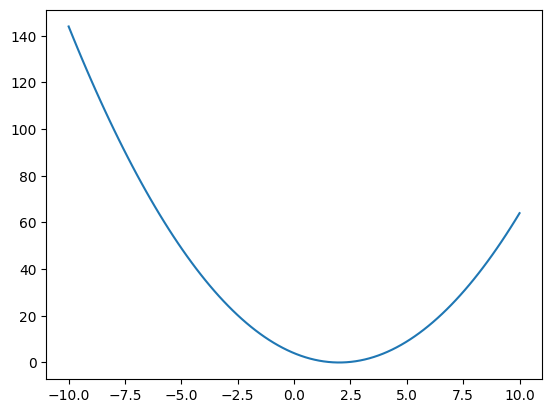

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xs = np.linspace(-10, 10, 100)

def f(x):
    return (x-2)**2

ys = f(xs)

plt.plot(xs, ys)

In [7]:
def grad(x):
    return 2*(x-2)

print(grad(-5))
print(grad(2))
print(grad(5))

-14
0
6


# Derivatives and Graph

In [8]:
from src.main.core import Scalar, Graph
from src.main.visualisation import draw_dot

In [9]:
a = Scalar(data=2.0, label="a"); a.grad = 6.0
b = Scalar(data=-3.0, label="b"); b.grad = -4.0
c = Scalar(data=10.0, label="c"); c.grad = -2.0

d = a * b; d.label = "d"; d.grad = -2.0
e = d + c; e.label = "e"; e.grad = -2.0
f = Scalar(data=-2.0, label="f"); f.grad = 4.0
L = e * f; L.label = "L"
L.grad = 1.0

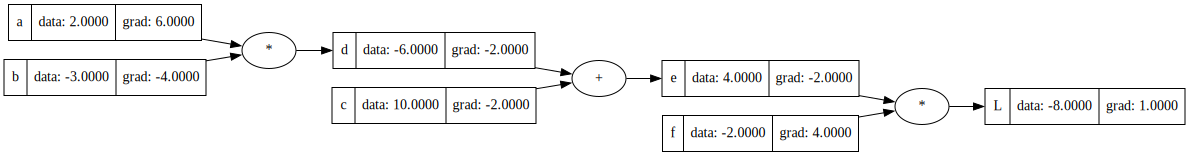

In [10]:
draw_dot(L)

## Derivatives by hand:

d(L)/dL = 1 * L^0 = 1.0

L = e * f = e^1 * f = e * f^1  

d(L)/de = 1 * e^0 * f = f = -2.0  
d(L)/df = e * 1 * f^0 = e = 4.0  

## Backpropagation > Chain rule

e = d + c

#### local derivates:  
d(e)/dd = 1.0  
d(e)/dc = 1.0  

#### chain rule:
d(L)/dd = d(L)/de * d(e)/dd = -2.0 * 1.0 = -2.0  
d(L)/dc = d(L)/de * d(e)/dc = -2.0 * 1.0 = -2.0  


d = a * b

#### local derivates:  
d(d)/da = b = -3.0  
d(d)/db = a = 2.0

#### chain rule:
d(L)/da = d(L)/de * d(e)/dd * d(d)/da = -2.0 * 1.0 * -3.0 = 6.0  
d(L)/db = d(L)/de * d(e)/dd * d(d)/db = -2.0 * 1.0 * 2.0 = -4.0  

## With other words

a.grad = b.data * d.grad  
b.grad = a.data * d.grad  
c.grad = e.grad  
d.grad = e.grad  
e.grad = L.grad * f.data  
f.grad = L.grad * e.data  
L.grad = 1.0  

from back to front:

=> (+) just distributes the gradient across nodes
=> (*) takes data of the other node and multiplies it with the gradient to get its gradient

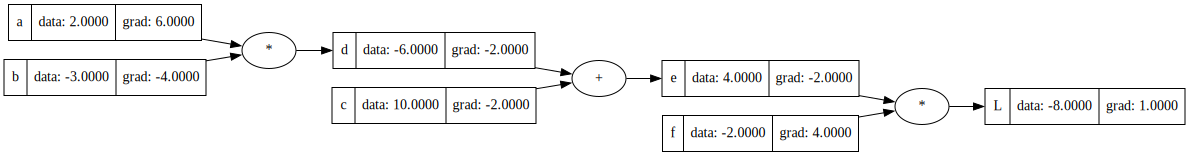

In [11]:
draw_dot(L)

In [12]:
# forward pass

step_size = 0.01

a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

d = a * b
e = c + d
L = e * f

L.data

-7.286496

## Neuron

In [13]:
# input values
x1 = Scalar(2.0, label="x1")
x2 = Scalar(0.0, label="x2")

# weights
w1 = Scalar(-3.0, label="w1")
w2 = Scalar(1.0, label="w2")

# bias
bias = Scalar(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
output = neuron.tanh(); output.label = "o"

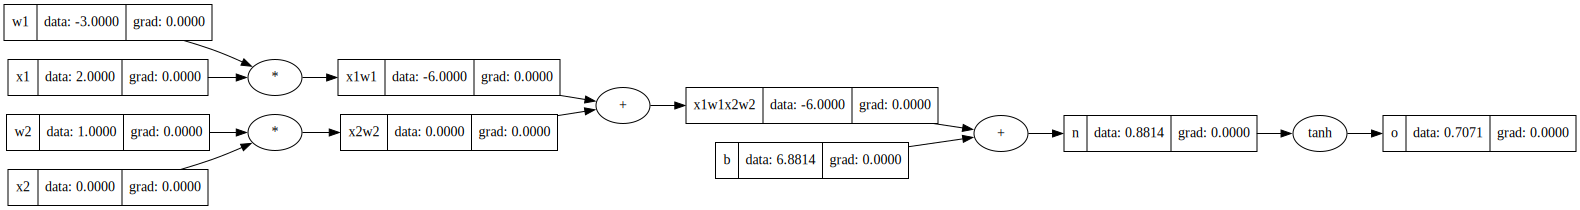

In [14]:
draw_dot(output)

### Automated backward propagation

In [15]:
output.backward()

### Semi automated backward progapagation

In [16]:
output.grad = 1.0

In [17]:
output._backward()

In [18]:
neuron._backward()

In [19]:
bias._backward()

In [20]:
x1w1x2w2._backward()

In [21]:
x2w2._backward()

In [22]:
x1w1._backward()

### Manuall backward propogation

In [23]:
import math

output.grad = 1.0

neuron.grad = 1 - math.tanh(neuron.data)**2 * output.grad # 0.5 => chain rule + derivative of tanh(x) according to wikipedia

bias.grad = neuron.grad # 0.5
x1w1x2w2.grad = neuron.grad # 0.5

x1w1.grad = x1w1x2w2.grad # 0.5
x2w2.grad = x1w1x2w2.grad # 0.5

x1.grad = w1.data * x1w1.grad # -1.5
w1.grad = x1.data * x1w1.grad # 1.0

x2.grad = w2.data * x2w2.grad # 0.5
w2.grad = x2.data * x2w2.grad # 0.0

## Derivatives

o = tanh(n)  
d(o)/dn = 1 - o^2 = 0.5 # wikipedia  


## Redesign tanh

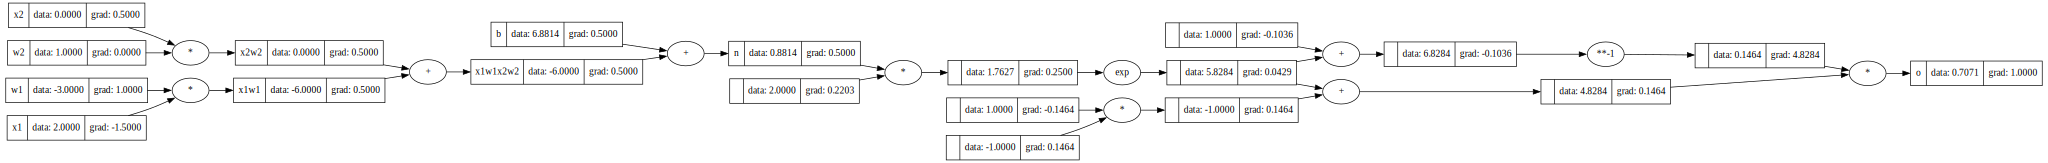

In [24]:
# input values
x1 = Scalar(2.0, label="x1")
x2 = Scalar(0.0, label="x2")

# weights
w1 = Scalar(-3.0, label="w1")
w2 = Scalar(1.0, label="w2")

# bias
bias = Scalar(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
# output = neuron.tanh()
exp = (2 * neuron).exp()
output = (exp - 1)/(exp + 1)

output.label = "o"
output.backward()
draw_dot(output)

## PyTorch comparison

In [25]:
import torch

In [26]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

bias = torch.Tensor([6.8813735870195432]).double(); bias.requires_grad = True

x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2

neuron = x1w1x2w2 + bias

output = torch.tanh(neuron)

print(f"output data: {output.data.item()}")
output.backward()

print("--- gradients ---")
print(f"w1 data: {w1.data.item()} | grad: {w1.grad.item()}")
print(f"x1 data: {x1.data.item()} | grad: {x1.grad.item()}")
print(f"w2 data: {w2.data.item()} | grad: {w2.grad.item()}")
print(f"x2 data: {x2.data.item()} | grad: {x2.grad.item()}")

output data: 0.7071066904050358
--- gradients ---
w1 data: -3.0 | grad: 1.0000002567688737
x1 data: 2.0 | grad: -1.5000003851533106
w2 data: 1.0 | grad: 0.0
x2 data: 0.0 | grad: 0.5000001283844369


# MLP - Multi layer perceptron

In [56]:
from src.main.nn import MLP

In [28]:
x = [2.0, 3.0, -1.0]
mlp = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
out = mlp(x)
print(out)

[Scalar(data=-0.3255031655635462)]


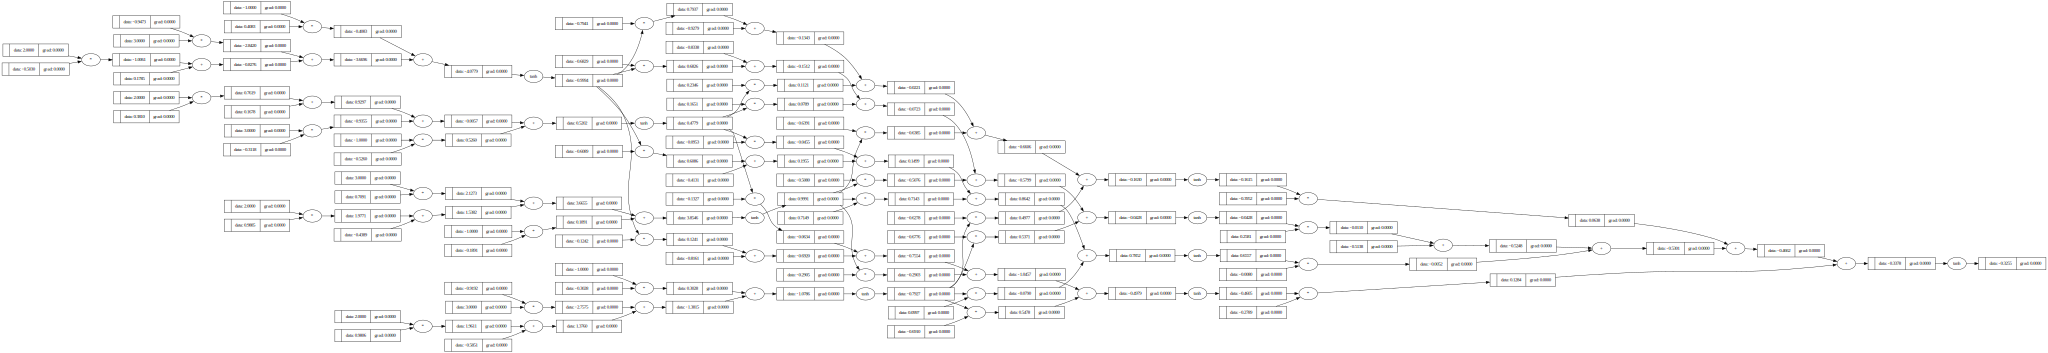

In [29]:
draw_dot(out[0])

# Training

## Simplest - single layer, single neuron perceptron

In [30]:
simple_model = MLP(no_inputs=1, no_layer_outputs=[1])

In [31]:
x = [2.0]
y = 1.0

prediction = simple_model(x)[0]
prediction

Scalar(data=-0.9785185025617412)

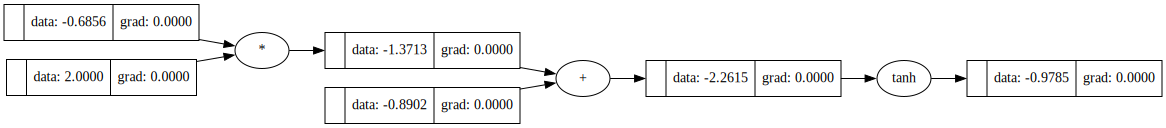

In [32]:
draw_dot(prediction)

In [33]:
# mse
loss = (prediction - y) ** 2
loss

Scalar(data=3.914535464979155)

In [34]:
loss.backward()

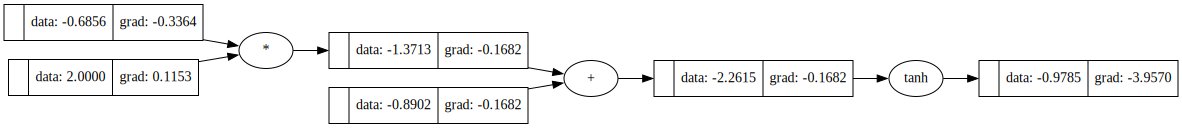

In [35]:
draw_dot(prediction)

weight (data=0.4823) was randomly initialiazed  
gradient (grad=-0.1147) was backpropagated through loss (mse)

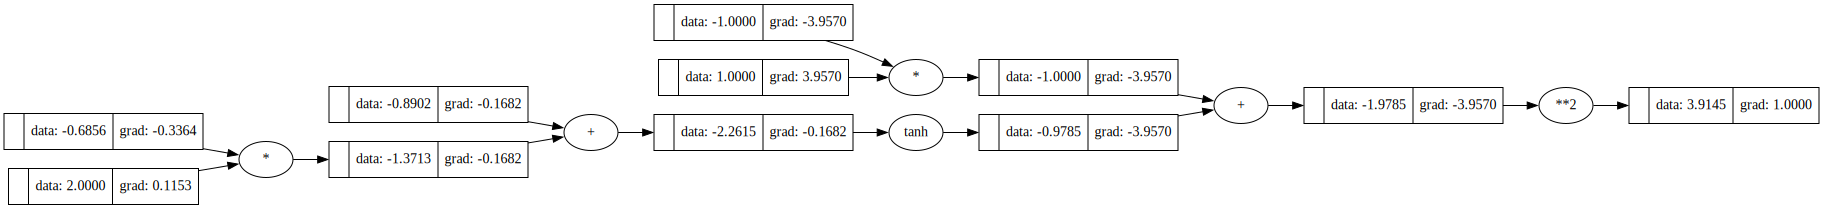

In [36]:
draw_dot(loss)

In [37]:
simple_model.layers[0].neurons[0].w[0].grad

-0.3363603342516912

gradient is negative => influence on loss is negative.  

increasing the weight of this neuron would make the loss go down.

## MLP

In [38]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])

In [39]:
# forward pass
y_preds = [model(x) for x in xs]
y_preds

[[Scalar(data=-0.9784693815609549)],
 [Scalar(data=-0.839742745582883)],
 [Scalar(data=-0.9641484317655579)],
 [Scalar(data=-0.960205660112603)]]

In [40]:
# mse loss
losses = [(y_pred[0] - y)**2 for y_pred, y in zip(y_preds, ys)]
losses

[Scalar(data=3.9143410937741874),
 Scalar(data=0.025682387593312574),
 Scalar(data=0.0012853349448688602),
 Scalar(data=3.8424062299374855)]

In [41]:
loss = sum(losses)
loss

Scalar(data=3.8693739524756667)

In [42]:
# backward pass
loss.backward()

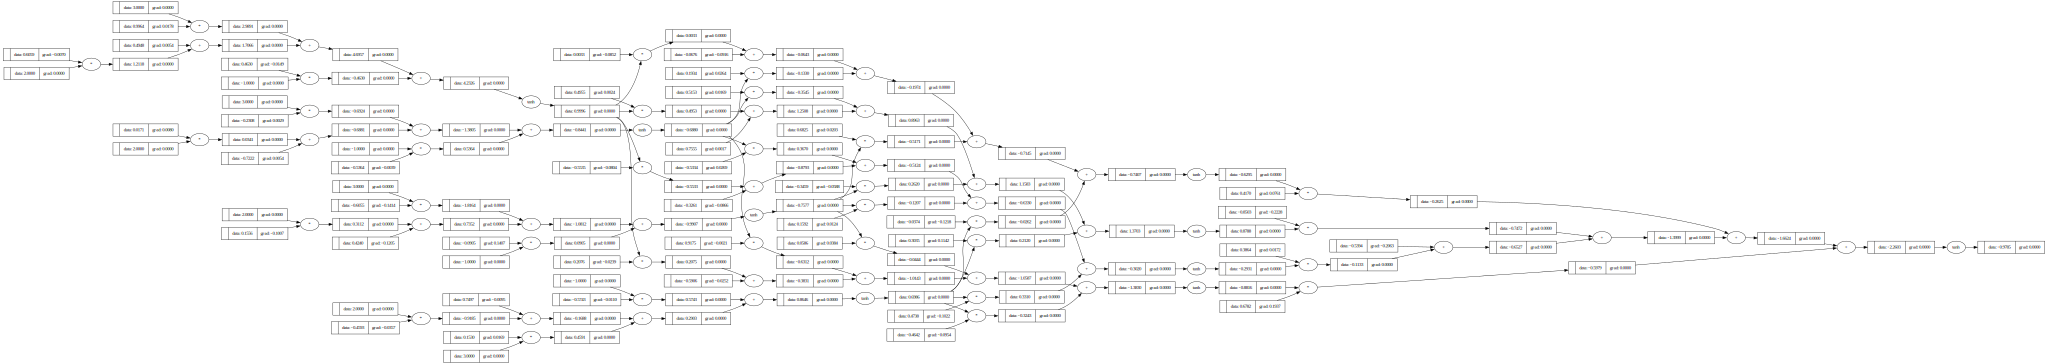

In [43]:
draw_dot(y_preds[0][0])

In [44]:
model.layers[0].neurons[0].w[0].grad

-0.007017354684668398

In [45]:
model.layers[0].neurons[0].w[0].data

0.6059074949119589

In [46]:
# update
step_size = 0.01

for param in model.parameters():
    param.data += -1 * step_size * param.grad  # modify the gradient by a small step size in the direction of the gradient

the direction of the gradient points in the direction which increases the loss => we want to decreate the loss => go in the opposite direction of the gradient => multiply by -1

In [47]:
model.layers[0].neurons[0].w[0].data

0.6059776684588056

### Full training loop - Gradient descent

In [57]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
model.summary()

===== Model Summary =====
1. Dense <src.main.nn.Layer object at 0x13ff13cd0>: 16 params
2. Dense <src.main.nn.Layer object at 0x13ff100a0>: 20 params
3. Dense <src.main.nn.Layer object at 0x13ff12f80>: 5 params
Total parameters: 41


In [49]:
no_epochs = 100
step_size = 0.01


for i in range(no_epochs):

    # forward pass
    y_preds = [model(x) for x in xs]
    
    # zero grad
    for param in model.parameters():
        param.grad = 0.0
    
    # mse loss
    losses = [(y_pred[0] - y)**2 for y_pred, y in zip(y_preds, ys)]
    loss = sum(losses)
    print(f"iteration {i} loss: {loss.data}")

    # backward pass
    loss.backward()
    
    # update of weights and biases
    for param in model.parameters():
        param.data += -1 * step_size * param.grad  # modify the gradient by a small step size in the direction of the gradient

iteration 0 loss: 2.620456417661833
iteration 1 loss: 2.5213582195836794
iteration 2 loss: 2.4216506453173956
iteration 3 loss: 2.3188650154871064
iteration 4 loss: 2.2113306672407127
iteration 5 loss: 2.098058275308371
iteration 6 loss: 1.9787565478997693
iteration 7 loss: 1.8539075247246726
iteration 8 loss: 1.7248145313147312
iteration 9 loss: 1.5935365685490641
iteration 10 loss: 1.4626610067104544
iteration 11 loss: 1.3349437645523343
iteration 12 loss: 1.2129187776544839
iteration 13 loss: 1.0985928780438896
iteration 14 loss: 0.9932928610973543
iteration 15 loss: 0.8976630817565854
iteration 16 loss: 0.8117673755131475
iteration 17 loss: 0.7352387378307662
iteration 18 loss: 0.6674319753558462
iteration 19 loss: 0.607553335569341
iteration 20 loss: 0.5547574480932491
iteration 21 loss: 0.5082123781133794
iteration 22 loss: 0.46713856095019257
iteration 23 loss: 0.4308286365062504
iteration 24 loss: 0.39865450888076576
iteration 25 loss: 0.3700665541604531
iteration 26 loss: 0.34

In [50]:
model.parameters()

[Scalar(data=-0.9096539170708511),
 Scalar(data=-0.505535553709871),
 Scalar(data=0.5112938210893561),
 Scalar(data=-0.943429774291112),
 Scalar(data=-0.5217754182701698),
 Scalar(data=-0.2841182695005966),
 Scalar(data=-0.3785325012715011),
 Scalar(data=0.7775793203687825),
 Scalar(data=0.6554626317046627),
 Scalar(data=0.353511559752489),
 Scalar(data=0.15845111412889468),
 Scalar(data=-0.30160892579746224),
 Scalar(data=0.2383152608992799),
 Scalar(data=0.14974666369807646),
 Scalar(data=0.8516048903226994),
 Scalar(data=-0.4154735991275461),
 Scalar(data=0.2691465581800246),
 Scalar(data=-0.23851008591865522),
 Scalar(data=0.7971007939976952),
 Scalar(data=-0.15702218651646097),
 Scalar(data=0.44756797210638793),
 Scalar(data=-0.9101325162143549),
 Scalar(data=0.35357292651890365),
 Scalar(data=-0.08729360422312188),
 Scalar(data=-1.1421732409544456),
 Scalar(data=-0.6242197418576644),
 Scalar(data=-0.12957422926633558),
 Scalar(data=0.06231345083633319),
 Scalar(data=0.83363166765

In [51]:
# trained model predictions
[model(x) for x in xs]

[[Scalar(data=-0.3677183458740243)],
 [Scalar(data=-0.9405749055506935)],
 [Scalar(data=-0.8896308668546329)],
 [Scalar(data=0.837508328590981)]]

### Fit method

In [52]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
model.summary()

===== Model Summary =====
1. layer: <src.main.nn.Layer object at 0x13fe150f0>: 16 params
2. layer: <src.main.nn.Layer object at 0x13ff21000>: 20 params
3. layer: <src.main.nn.Layer object at 0x12ddab580>: 5 params
Total parameters: 41


In [53]:
history = model.fit(x=xs, y=ys, lr=0.05, epochs=100)

iteration 0 loss: 6.088566396081146
iteration 1 loss: 2.7521064754812
iteration 2 loss: 1.4040049139800257
iteration 3 loss: 0.6499612785709389
iteration 4 loss: 0.338560210753003
iteration 5 loss: 0.2540001529298817
iteration 6 loss: 0.20368537047372487
iteration 7 loss: 0.16963490766962724
iteration 8 loss: 0.14507201523231775
iteration 9 loss: 0.1265201693303914
iteration 10 loss: 0.11201552373848767
iteration 11 loss: 0.10036595444076671
iteration 12 loss: 0.09080608234160548
iteration 13 loss: 0.0828219798722947
iteration 14 loss: 0.07605568334515898
iteration 15 loss: 0.07025014506530668
iteration 16 loss: 0.06521597015306826
iteration 17 loss: 0.06081050384618346
iteration 18 loss: 0.05692423054238499
iteration 19 loss: 0.05347166541901443
iteration 20 loss: 0.05038509687162211
iteration 21 loss: 0.047610189765061324
iteration 22 loss: 0.045102833942195567
iteration 23 loss: 0.0428268447375416
iteration 24 loss: 0.040752258114556184
iteration 25 loss: 0.03885404827788179
iterati

In [54]:
preds = [model(x) for x in xs]
preds

[[Scalar(data=0.976647742913969)],
 [Scalar(data=-0.9602787258916622)],
 [Scalar(data=-0.9465864640697536)],
 [Scalar(data=0.9442682694431568)]]

In [55]:
history

{'epochs': {0: {'loss': 6.088566396081146},
  1: {'loss': 2.7521064754812},
  2: {'loss': 1.4040049139800257},
  3: {'loss': 0.6499612785709389},
  4: {'loss': 0.338560210753003},
  5: {'loss': 0.2540001529298817},
  6: {'loss': 0.20368537047372487},
  7: {'loss': 0.16963490766962724},
  8: {'loss': 0.14507201523231775},
  9: {'loss': 0.1265201693303914},
  10: {'loss': 0.11201552373848767},
  11: {'loss': 0.10036595444076671},
  12: {'loss': 0.09080608234160548},
  13: {'loss': 0.0828219798722947},
  14: {'loss': 0.07605568334515898},
  15: {'loss': 0.07025014506530668},
  16: {'loss': 0.06521597015306826},
  17: {'loss': 0.06081050384618346},
  18: {'loss': 0.05692423054238499},
  19: {'loss': 0.05347166541901443},
  20: {'loss': 0.05038509687162211},
  21: {'loss': 0.047610189765061324},
  22: {'loss': 0.045102833942195567},
  23: {'loss': 0.0428268447375416},
  24: {'loss': 0.040752258114556184},
  25: {'loss': 0.03885404827788179},
  26: {'loss': 0.037111150343467895},
  27: {'los